In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/mvaldenegro/keras-uncertainty.git
!pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git

fatal: destination path 'keras-uncertainty' already exists and is not an empty directory.
  Cloning https://github.com/mvaldenegro/keras-uncertainty.git to /tmp/pip-req-build-kxcgg0fa
  Running command git clone -q https://github.com/mvaldenegro/keras-uncertainty.git /tmp/pip-req-build-kxcgg0fa


In [3]:
%cd keras-uncertainty

/content/keras-uncertainty


In [4]:
import numpy as np
import math

import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

import keras_uncertainty
from keras_uncertainty.models import MCDropoutRegressor, DeepEnsembleRegressor, StochasticRegressor, TwoHeadStochasticRegressor
from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense
from keras_uncertainty.metrics import gaussian_interval_score
from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

Keras Uncertainty will use standalone Keras backend

In [5]:
# error if the eager execution is not disabled that the keras tensor 
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [9]:
def toy_function(input):
    output = []

    for inp in input:
        std = max(0.15 / (1.0 + math.exp(-inp)), 0)

        out = math.sin(inp) + np.random.normal(0, std)
        output.append(10 * out)

    return np.array(output)

def train_standard_model(x_train, y_train, x_val, y_val, x_test, epochs):
    inp = Input(shape=(1,))
    x = Dense(32, activation="relu")(inp)
    x = Dense(32, activation="relu")(x)
    mean = Dense(1, activation="linear")(x)
    var = Dense(1, activation="softplus")(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer="adam")
    train_model.fit(x_train, y_train, verbose=2, validation_data=(x_val, y_val), epochs=epochs)

    mean_pred, var_pred = pred_model.predict(x_test)
    std_pred = np.sqrt(var_pred)

    return mean_pred, std_pred

def train_dropout_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob=0.2):
    model = Sequential()
    model.add(Dense(32, activation="tanh", input_shape=(1,)))
    model.add(Dropout(prob))
    model.add(Dense(32, activation="tanh"))
    model.add(Dropout(prob))
    model.add(Dense(1, activation="linear"))

    model.compile(loss="mean_squared_error", optimizer='sg')

    model.fit(x_train, y_train, verbose=2, validation_data=(x_val, y_val), epochs=epochs)

    mc_model = MCDropoutRegressor(model)
    pred_mean, pred_std = mc_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

def train_dropconnect_model(x_train, y_train, x_Val, y_val, x_test, epochs, num_samples, prob=0.05, noise_shape=None):
    model = Sequential()
    model.add(DropConnectDense(32, activation="tanh", input_shape=(1,), prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(32, activation="tanh", prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(1, activation="linear", noise_shape=noise_shape))

    model.compile(loss="mean_squared_error", optimizer="sgd")

    model.fit(x_train, y_train, verbose=2, validation_data=(x_val, y_val), epochs=epochs)

    mc_model = MCDropoutRegressor(model)
    pred_mean, pred_std = mc_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

def train_ensemble_model(x_train, y_train, x_val, y_val, x_test, epochs, num_estimators):
    def model_fn():
        inp = Input(shape=(1,))
        x = Dense(32, activation="tanh")(inp)
        x = Dense(32, activation="tanh")(x)
        mean = Dense(1, activation="linear")(x)
        var = Dense(1, activation="softplus")(x)

        train_model = Model(inp, mean)
        pred_model = Model(inp, [mean, var])

        train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer="sgd")

        return train_model, pred_model
    
    model = DeepEnsembleRegressor(model_fn, num_estimators=num_estimators)
    model.fit(x_train, y_train, verbose=2, validation_data=(x_val, y_val), epochs=epochs)
    pred_mean, pred_std = model.predict(x_test)

    return pred_mean, pred_std

def train_bayesbackprop_model(x_train, y_train, domain):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches
    prior_params = {
        'prior_sigma_1': 5.0, 
        'prior_sigma_2': 2.0, 
        'prior_pi': 0.5
    }

    model = Sequential()
    model.add(VariationalDense(32, kl_weight, **prior_params, prior=True, activation="relu", input_shape=(1,)))
    model.add(VariationalDense(32, kl_weight, **prior_params, prior=True, activation="relu"))
    model.add(VariationalDense(1, kl_weight, **prior_params, prior=True, activation="linear"))

    model.compile(loss="mean_squared_error", optimizer="adam")

    model.fit(x_train, y_train, verbose=2, epochs=10)

    st_model = StochasticRegressor(model)
    pred_mean, pred_std = st_model.predict(domain, num_samples=50)

    return pred_mean, pred_std

def train_flipout_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches
    prior_params = {
        'prior_sigma_1': 1.0, 
        'prior_sigma_2': 2.0, 
        'prior_pi': 0.5
    }

    model = Sequential()
    model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="tanh"))
    model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="tanh"))
    model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="linear"))

    model.compile(loss="mean_squared_error", optimizer="sgd")

    model.summary()

    model.fit(x_train, y_train, verbose=2, validation_data=(x_val, y_val), epochs=epochs)
    
    st_model = StochasticRegressor(model)
    pred_mean, pred_std = st_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

def train_flipout_nll_model(x_train, y_train, domain):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches

    inp = Input(shape=(1,))
    x = FlipoutDense(32, kl_weight, activation="relu",)(inp)
    x = FlipoutDense(32, kl_weight, activation="relu")(x)
    mean = FlipoutDense(1, kl_weight, activation="linear")(x)
    var = FlipoutDense(1, kl_weight, activation="softplus")(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer="adam")
    train_model.fit(x_train, y_train, verbose=2, epochs=10)

    st_model = TwoHeadStochasticRegressor(pred_model)
    pred_mean, std_pred = st_model.predict(domain, num_samples=50)

    return pred_mean, std_pred

def train_flipout_beta_nll_model(x_train, y_train, domain):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches

    inp = Input(shape=(1,))
    x = FlipoutDense(32, kl_weight, activation="relu",)(inp)
    x = FlipoutDense(32, kl_weight, activation="relu")(x)
    mean = FlipoutDense(1, kl_weight, activation="linear")(x)
    var = FlipoutDense(1, kl_weight, activation="softplus")(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=regression_gaussian_beta_nll_loss(var), optimizer="adam")
    train_model.fit(x_train, y_train, verbose=2, epochs=10)

    st_model = TwoHeadStochasticRegressor(pred_model)
    pred_mean, std_pred = st_model.predict(domain, num_samples=50)

    return pred_mean, std_pred

train data shape  (1200,)
train label shape  (1200,)
test data shape  (1000, 1)
test label shape  (1000,)
domain shape  (1000, 1)
Train on 1200 samples, validate on 200 samples
Epoch 1/10
1200/1200 - 0s - loss: 43.7044 - val_loss: 48.4242 - 358ms/epoch - 298us/sample
Epoch 2/10
1200/1200 - 0s - loss: 43.9384 - val_loss: 49.3700 - 62ms/epoch - 51us/sample
Epoch 3/10
1200/1200 - 0s - loss: 43.8721 - val_loss: 49.0471 - 49ms/epoch - 41us/sample


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 4/10
1200/1200 - 0s - loss: 44.1862 - val_loss: 47.9751 - 57ms/epoch - 47us/sample
Epoch 5/10
1200/1200 - 0s - loss: 44.3180 - val_loss: 49.2727 - 64ms/epoch - 53us/sample
Epoch 6/10
1200/1200 - 0s - loss: 43.9092 - val_loss: 48.9202 - 60ms/epoch - 50us/sample
Epoch 7/10
1200/1200 - 0s - loss: 42.7951 - val_loss: 49.3909 - 75ms/epoch - 62us/sample
Epoch 8/10
1200/1200 - 0s - loss: 42.6903 - val_loss: 48.5090 - 74ms/epoch - 61us/sample
Epoch 9/10
1200/1200 - 0s - loss: 41.5856 - val_loss: 49.4970 - 57ms/epoch - 48us/sample
Epoch 10/10
1200/1200 - 0s - loss: 41.3069 - val_loss: 47.0456 - 60ms/epoch - 50us/sample


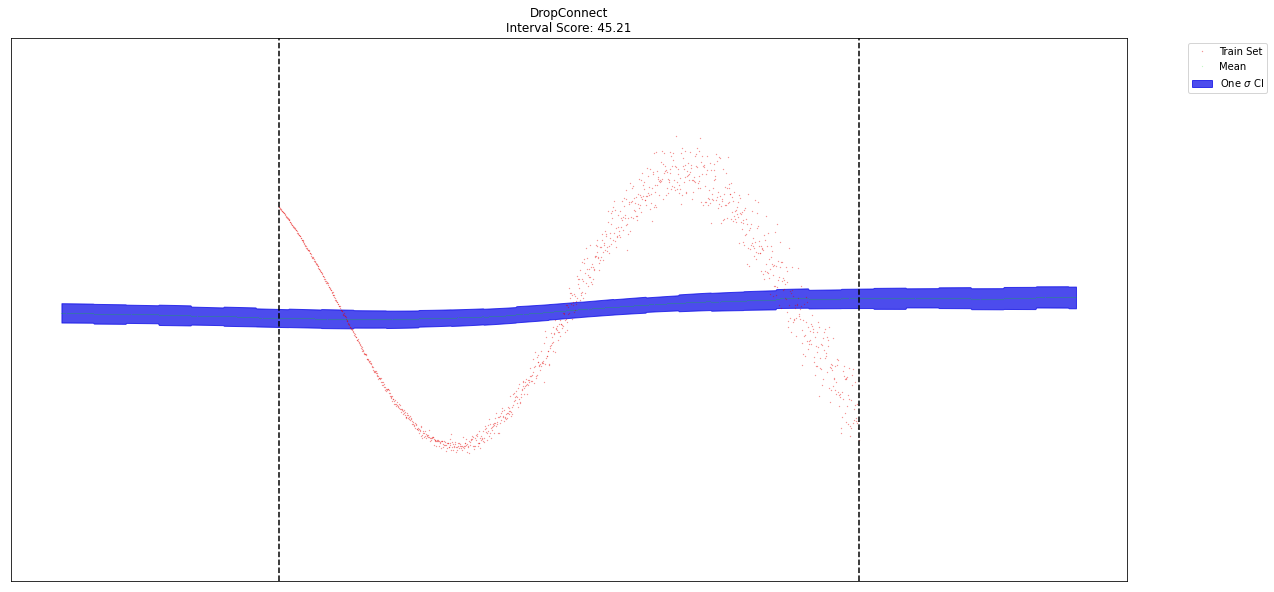

In [13]:
'''
METHODS = {
    "Classical NN": train_standard_model,
    "Dropout": train_dropout_model,
    "DropConnect": train_dropconnect_model,
    "5 Ensembles": train_ensemble_model,
    "Flipout": train_flipout_model,
    "Flipout + NLL": train_flipout_nll_model,
    "Flipout + Beta-NLL": train_flipout_beta_nll_model
}
'''

METHODS = {
    "DropConnect": train_dropconnect_model
}


num_samples = 300
epochs = 10

if __name__ == "__main__":
    fig, axes = plt.subplots(nrows=1, ncols=len(METHODS.keys()), figsize=(20, 10))
    methods = list(METHODS.keys())

    x_train = np.linspace(-4.0, 4.0, num=1200)
    x_val = np.linspace(-7.0, 7.0, num=200)

    y_train = toy_function(x_train)
    y_val = toy_function(x_val)

    x_test = np.linspace(-7.0, 7.0, num=1000)
    x_test = x_test.reshape((-1, 1))
    print('train data shape ', x_train.shape)
    print('train label shape ', y_train.shape)
    
    y_test = toy_function(x_test)
    print('test data shape ', x_test.shape)
    print('test label shape ', y_test.shape)
    print('domain shape ', x_test.shape)

   

    for i, key in enumerate(methods):
        
        ax = axes

        y_pred_mean, y_pred_std = METHODS[key](x_train, y_train, x_val, y_val, x_test, epochs, num_samples)
        
        #print('y_pred_mean shape ', y_pred_mean.shape)
        #print('y_pred_mean ', y_pred_std)
        #print('y_pred_std shape ', y_pred_std.shape)
        #print('y_pred_std ', y_pred_std)

        score = gaussian_interval_score(y_test, y_pred_mean, y_pred_std)

        y_pred_mean = y_pred_mean.reshape((-1,))
        y_pred_std = y_pred_std.reshape((-1,))
        y_pred_up_1 = y_pred_mean + y_pred_std
        y_pred_down_1 = y_pred_mean - y_pred_std

        ax.plot(x_train, y_train, '.', color=(0.9, 0.0, 0.0, 0.7), markersize=0.5, label="Train Set")

        ax.fill_between(x_test.ravel(), y_pred_down_1, y_pred_up_1, color=(0, 0, 0.9, 0.7), label="One $\sigma$ CI")
        ax.plot(x_test.ravel(), y_pred_mean, '.', color=(0, 0.9, 0.0, 0.8), markersize=0.2, label="Mean")

        ax.set_title("{}\nInterval Score: {:.2f}".format(key, score))
        ax.set_ylim([-20.0, 20.0])

        ax.axvline(x=-4.0, color="black", linestyle="dashed")
        ax.axvline(x= 4.0, color="black", linestyle="dashed")
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.savefig("uncertainty-toy-regression.png", bbox_inches="tight")
    #plt.savefig("uncertainty-toy-regression.pdf", bbox_inches="tight")
    plt.show()